In [1]:
%matplotlib inline
import os
import sys
curr_path = os.getcwd()
gerkin_path = os.path.split(curr_path)[0]
olfaction_prediction_path = os.path.split(gerkin_path)[0]
sys.path.append(olfaction_prediction_path)
import opc_python
import numpy as np
import matplotlib.pyplot as plt
import pandas
from opc_python.utils import loading, scoring
from opc_python.gerkin import dream,fit1,fit2,params

In [2]:
# Get all Chemical IDs and located the data directory.  
all_CIDs = sorted(loading.get_CIDs('training')+loading.get_CIDs('leaderboard')+loading.get_CIDs('testset'))
mdx = dream.get_molecular_data(['dragon','episuite','morgan','nspdk','gramian'],all_CIDs)

Episuite has 62 features for 476 molecules.
Morgan has 2437 features for 476 molecules.
NSPDK has 6163 features for 476 molecules.
NSPDK Gramian has 2437 features for 476 molecules.
There are now 15969 total features.


### Create matrices

In [3]:
# Create the feature matrices from the feature dicts.  
# Create the feature matrices from the feature dicts.  
X_train,good1,good2,means,stds,imputer = dream.make_X(mdx,['training'])
X_test_other,good1,good2,means,stds,imputer = dream.make_X(mdx,'leaderboard',target_dilution='high',good1=good1,good2=good2,means=means,stds=stds)
X_test_int,good1,good2,means,stds,imputer = dream.make_X(mdx,'leaderboard',target_dilution=-3,good1=good1,good2=good2,means=means,stds=stds)

The X matrix now has shape (676x13914) molecules by non-NaN good molecular descriptors
The X matrix now has shape (69x13914) molecules by non-NaN good molecular descriptors
The X matrix now has shape (69x13914) molecules by non-NaN good molecular descriptors


In [4]:
# Create descriptor matrices for the training set.  
# One is done with median imputation, and the other by masking missing values.  
Y_train_imp,imputer = dream.make_Y_obs(['training'],target_dilution=None,imputer='median')
Y_train_mask,imputer = dream.make_Y_obs(['training'],target_dilution=None,imputer='mask')

The Y['mean_std'] matrix now has shape (676x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (676x21) molecules by perceptual descriptors, one for each subject
The Y['mean_std'] matrix now has shape (676x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (676x21) molecules by perceptual descriptors, one for each subject


In [5]:
# Create descriptor matrices for the leaderboard set.  
Y_test_mask,imputer = dream.make_Y_obs('leaderboard',target_dilution='gold',imputer='mask')

The Y['mean_std'] matrix now has shape (69x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (69x21) molecules by perceptual descriptors, one for each subject


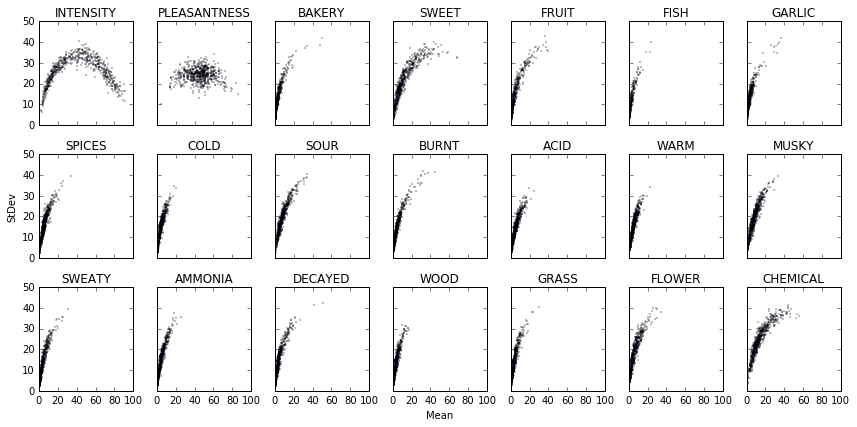

In [6]:
perceptual_headers,_ = loading.load_perceptual_data('training')
Y = Y_train_mask

# Plot stdev vs mean for each descriptor, and fit to a theoretically-motivated function.  
# These fit parameters will be used in the final model fit.  
def f_transformation(x, k0=1.0, k1=1.0):
    return 100*(k0*(x/100)**(k1*0.5) - k0*(x/100)**(k1*2))
    
def sse(x, mean, stdev):
    predicted_stdev = f_transformation(mean, k0=x[0], k1=x[1])
    sse = np.sum((predicted_stdev - stdev)**2)
    return sse
    
fig,axes = plt.subplots(3,7,sharex=True,sharey=True,figsize=(12,6))
ax = axes.flat
trans_params = {col:None for col in range(21)}
from scipy.optimize import minimize
for col in range(len(ax)):    
    Y_mean = Y['mean_std'][:,col]
    Y_stdev = Y['mean_std'][:,col+21]
    x = [1.0,1.0]
    res = minimize(sse, x, args=(Y_mean,Y_stdev), method='L-BFGS-B')
    trans_params[col] = res.x # We will use these for our transformations.  
    ax[col].scatter(Y_mean,Y_stdev,s=0.1)
    x_ = np.linspace(0,100,100)
    #ax[col].plot(x_,f_transformation(x_, k0=res.x[0], k1=res.x[1]))
    ax[col].set_title(perceptual_headers[col+6].split('/')[1 if col==1 else 0])
    ax[col].set_xlim(0,100)
    ax[col].set_ylim(0,50)
    if col == 17:
        ax[col].set_xlabel('Mean')
    if col == 7:
        ax[col].set_ylabel('StDev')
plt.tight_layout()

In [7]:
# Load optimal parameters (obtained from extensive cross-validation).
cols = range(42)
def get_params(i):
    return {col:params.best[col][i] for col in cols}

use_et = get_params(0)
max_features = get_params(1)
max_depth = get_params(2)
min_samples_leaf = get_params(3)
trans_weight = get_params(4)
regularize = get_params(4)
use_mask = get_params(5)
for col in range(21):
    trans_weight[col] = trans_weight[col+21]

In [16]:
from sklearn.preprocessing import Imputer

def get_y(Y, subjects):
    y = np.dstack([Y['subject'][i] for i in range(1,50)])
    y_mask = y[:,:,subjects].copy()
    #imputer = Imputer(missing_values=np.nan,strategy='median',axis=1)
    #y_imp = np.zeros((y.shape[0],21,len(subjects)))
    #for i in range(21):
    #    y_imp[:,i,:] = imputer.fit_transform(y[:,i,subjects].data)
    y_imp = y_mask.copy()
    Y_mean = np.ma.mean(y_imp,axis=2)
    Y_std = np.ma.std(y_mask,axis=2)
    Y = np.hstack((Y_mean,Y_std))
    return Y

n_splits = 50
n_estimators = 50
all_rs = np.zeros((49,n_splits,3,2))

for i in range(10,49,5):
    print("For %d subjects" % i)
    for j in range(n_splits):
        subjects = np.random.choice(range(49),i)
        Y_train = get_y(Y_train_mask, subjects)
        Y_test = get_y(Y_test_mask, subjects)
        
        rfcs_norep,score,rs = fit2.rfc_final(X_train,Y_train,Y_train,max_features,
                                           min_samples_leaf,max_depth,use_et,use_mask,
                                           trans_weight,trans_params,X_test_int=X_test_int,
                                           X_test_other=X_test_other,Y_test=Y_test,
                                           n_estimators=n_estimators,quiet=True)
        all_rs[i,j,0,0] = rs['int']['mean']
        all_rs[i,j,1,0] = rs['ple']['mean']
        all_rs[i,j,2,0] = rs['dec']['mean']
        all_rs[i,j,0,1] = rs['int']['sigma']
        all_rs[i,j,1,1] = rs['ple']['sigma']
        all_rs[i,j,2,1] = rs['dec']['sigma']

For 10 subjects
97.62% [------------------------------------------------- ]For 15 subjects
97.62% [------------------------------------------------- ]For 20 subjects
97.62% [------------------------------------------------- ]For 25 subjects
97.62% [------------------------------------------------- ]For 30 subjects
97.62% [------------------------------------------------- ]For 35 subjects
97.62% [------------------------------------------------- ]For 40 subjects
97.62% [------------------------------------------------- ]For 45 subjects
97.62% [------------------------------------------------- ]

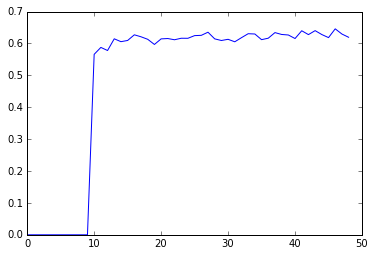

In [15]:
plt.plot(all_rs[:,:,0,0].mean(axis=1))

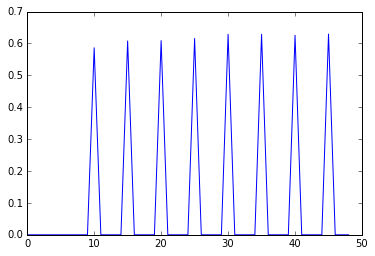

In [17]:
plt.plot(all_rs[:,:,0,0].mean(axis=1))